# Подключение библиотек

In [1]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob
import random

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

print(device)

cpu


#### Разделение набора данных на выборки

In [3]:
train_path=os.path.abspath('train_list')
test_path=os.path.abspath('test_list')
val_path=os.path.abspath('val_list')


df = pd.read_csv('annotation.csv', sep = ',', header=None)

df = df.drop(df.index[0])
df.drop(0, axis=1, inplace=True)
df.rename(columns={1: 'full_path', 2: 'img_class'}, inplace=True)
df.reset_index(inplace=True)
print(df)


if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)

if not os.path.isdir(val_path):
    os.mkdir(val_path)

def load_train(df: pd.core.frame.DataFrame, path: str, i: int) -> None:    
   
    
    image_path = os.path.abspath(os.path.join(*df.full_path[i].split("\\")))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{df.img_class[i]}.{i}.jpg'), image)

def load_val(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
 
    image_path = os.path.join(*df.full_path[i].split("\\"))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(*path.split("/"), f'{i}.jpg'), image)

def load_test(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
 
    image_path = os.path.join(*df.full_path[i].split("\\"))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)


for i in range(800):
    load_train(df, train_path, i)
for i in range(1000,1800):
    load_train(df, train_path, i)
for i in range(800,900):
    load_test(df,test_path,i)
for i in range(1800,1900):
    load_test(df,test_path,i)
for i in range(900,1000):
    load_val(df,val_path,i)
for i in range(1900,1999):
    load_val(df,val_path,i)

train_list = glob.glob(os.path.join(train_path,'*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))

train_list, val_list = train_test_split(train_list, test_size=0.1)

      index             full_path img_class
0         1  dataset\cat\0000.jpg       cat
1         2  dataset\cat\0001.jpg       cat
2         3  dataset\cat\0002.jpg       cat
3         4  dataset\cat\0003.jpg       cat
4         5  dataset\cat\0004.jpg       cat
...     ...                   ...       ...
1995   1996  dataset\dog\0995.jpg       dog
1996   1997  dataset\dog\0996.jpg       dog
1997   1998  dataset\dog\0997.jpg       dog
1998   1999  dataset\dog\0998.jpg       dog
1999   2000  dataset\dog\0999.jpg       dog

[2000 rows x 3 columns]


#### Проверка картинок

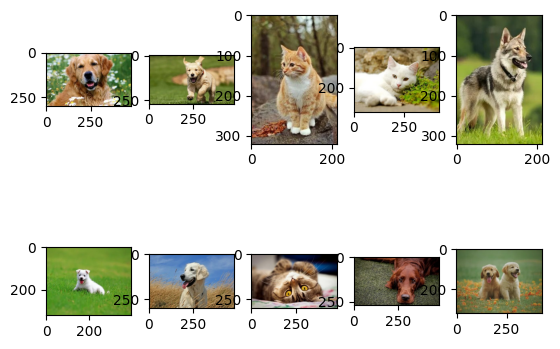

In [4]:
random_idx = np.random.randint(1,200,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = cv2.imread(train_list[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i+=1

plt.show()

##### Увеличение изображений

In [5]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

#### Загрузка наборов

In [6]:
from PIL import Image
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

In [7]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

In [8]:
print(train_data[1])
print(val_data[0][1])

(tensor([[[0.4353, 0.4353, 0.4353,  ..., 0.4784, 0.4784, 0.4784],
         [0.4353, 0.4353, 0.4353,  ..., 0.4784, 0.4784, 0.4784],
         [0.4353, 0.4353, 0.4353,  ..., 0.4784, 0.4784, 0.4784],
         ...,
         [0.4941, 0.4941, 0.4902,  ..., 0.8549, 0.8510, 0.8510],
         [0.4902, 0.4902, 0.4863,  ..., 0.8510, 0.8431, 0.8431],
         [0.4902, 0.4902, 0.4863,  ..., 0.8510, 0.8431, 0.8431]],

        [[0.7294, 0.7294, 0.7294,  ..., 0.7412, 0.7412, 0.7412],
         [0.7294, 0.7294, 0.7294,  ..., 0.7412, 0.7412, 0.7412],
         [0.7294, 0.7294, 0.7294,  ..., 0.7412, 0.7412, 0.7412],
         ...,
         [0.3922, 0.3922, 0.3882,  ..., 0.6706, 0.6667, 0.6667],
         [0.3882, 0.3882, 0.3843,  ..., 0.6627, 0.6549, 0.6549],
         [0.3882, 0.3882, 0.3843,  ..., 0.6627, 0.6549, 0.6549]],

        [[0.4588, 0.4588, 0.4588,  ..., 0.4706, 0.4706, 0.4706],
         [0.4588, 0.4588, 0.4588,  ..., 0.4706, 0.4706, 0.4706],
         [0.4588, 0.4588, 0.4588,  ..., 0.4706, 0.4706, 0

# Обучение

In [9]:
lr = 0.001 # learning_rate
batch_size = 10 # we will use mini-batch method
epochs = 10 # How much to train a model

In [10]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

In [11]:
print(len(train_data), len(train_loader))

1440 144


In [12]:
print(len(val_data), len(val_loader))

160 16


#### Построение модели

In [13]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )


        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()


    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [14]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [15]:
print(len(train_data), len(train_loader))
print(len(val_data), len(val_loader))
train_data[0][0].shape

1440 144
160 16


torch.Size([3, 224, 224])

Epoch : 1, train accuracy : 0.5986114740371704, train loss : 0.6668837070465088
Epoch : 1, val_accuracy : 0.668749988079071, val_loss : 0.6371417045593262
Epoch : 2, train accuracy : 0.6520835161209106, train loss : 0.6350711584091187
Epoch : 2, val_accuracy : 0.6937500238418579, val_loss : 0.6004744172096252
Epoch : 3, train accuracy : 0.6729167699813843, train loss : 0.6089128851890564
Epoch : 3, val_accuracy : 0.71875, val_loss : 0.5630094408988953
Epoch : 4, train accuracy : 0.7055560946464539, train loss : 0.572670042514801
Epoch : 4, val_accuracy : 0.7250000834465027, val_loss : 0.5509910583496094
Epoch : 5, train accuracy : 0.7159724831581116, train loss : 0.5496745109558105
Epoch : 5, val_accuracy : 0.7562500238418579, val_loss : 0.4852003753185272
Epoch : 6, train accuracy : 0.7208337783813477, train loss : 0.5451843738555908
Epoch : 6, val_accuracy : 0.768750011920929, val_loss : 0.47960180044174194
Epoch : 7, train accuracy : 0.7215281128883362, train loss : 0.54000443220138

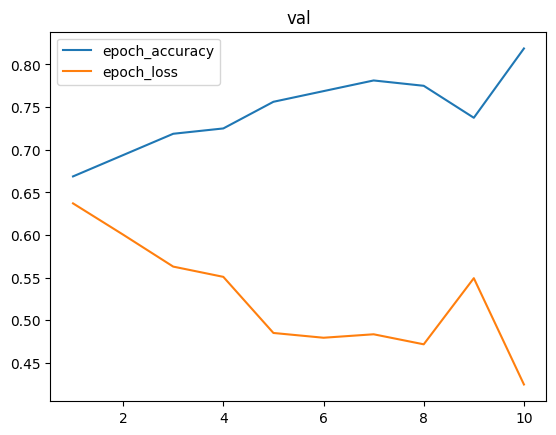

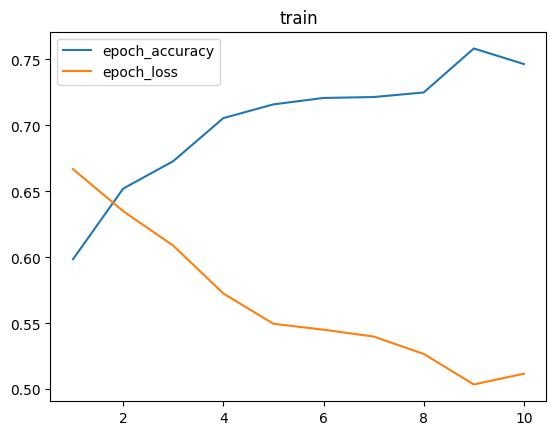

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)

def train(model, epochs):
  epoch_val_accuracy_list = []
  epoch_val_loss_list = []
  epoch_accuracy_list = []
  epoch_loss_list = []


  for epoch in range(epochs):
      epoch_loss = 0
      epoch_accuracy = 0

      for data, label in train_loader:
          data = data.to(device)
          label = label.to(device)

          output = model(data)
          loss = criterion(output, label)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          acc = ((output.argmax(dim=1) == label).float().mean())
          epoch_accuracy += acc/len(train_loader)
          epoch_loss += loss/len(train_loader)

      print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
      epoch_accuracy_list.append(epoch_accuracy)
      epoch_loss_list.append(epoch_loss)
      with torch.no_grad():
          epoch_val_accuracy=0
          epoch_val_loss =0
          for data, label in val_loader:
              data = data.to(device)
              label = label.to(device)
              val_output = model(data)
              val_loss = criterion(val_output,label)


              acc = ((val_output.argmax(dim=1) == label).float().mean())
              epoch_val_accuracy += acc/ len(val_loader)
              epoch_val_loss += val_loss/ len(val_loader)

          print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

      epoch_val_accuracy_list.append(epoch_val_accuracy)
      epoch_val_loss_list.append(epoch_val_loss)

  return(epoch_val_accuracy_list,epoch_val_loss_list,
  epoch_accuracy_list,
  epoch_loss_list)

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

def show_plot(accuracy_list, loss_list, text):
  x = list(range(1, len(accuracy_list)+ 1))
  plt.plot(x, accuracy_list, label = "epoch_accuracy")
  plt.plot(x, loss_list, label = "epoch_loss")
  plt.title(text)
  plt.legend()
  plt.show()

show_plot(epoch_val_accuracy_list, epoch_val_loss_list, "val")
show_plot(epoch_accuracy_list, [i.data for i in epoch_loss_list], "train")

Epoch : 1, train accuracy : 0.7589654922485352, train loss : 0.4763902425765991
Epoch : 1, val_accuracy : 0.7700000405311584, val_loss : 0.4970732033252716
Epoch : 2, train accuracy : 0.7836206555366516, train loss : 0.45234423875808716
Epoch : 2, val_accuracy : 0.7899999618530273, val_loss : 0.47752949595451355
Epoch : 3, train accuracy : 0.8005172610282898, train loss : 0.4366535544395447
Epoch : 3, val_accuracy : 0.7749999761581421, val_loss : 0.4245883822441101
Epoch : 4, train accuracy : 0.7912068963050842, train loss : 0.4326840937137604
Epoch : 4, val_accuracy : 0.8200000524520874, val_loss : 0.36923378705978394
Epoch : 5, train accuracy : 0.7829309105873108, train loss : 0.4417065978050232
Epoch : 5, val_accuracy : 0.8349999785423279, val_loss : 0.4144546091556549
Epoch : 6, train accuracy : 0.806034505367279, train loss : 0.41350165009498596
Epoch : 6, val_accuracy : 0.8199999928474426, val_loss : 0.37406760454177856
Epoch : 7, train accuracy : 0.7934483289718628, train loss :

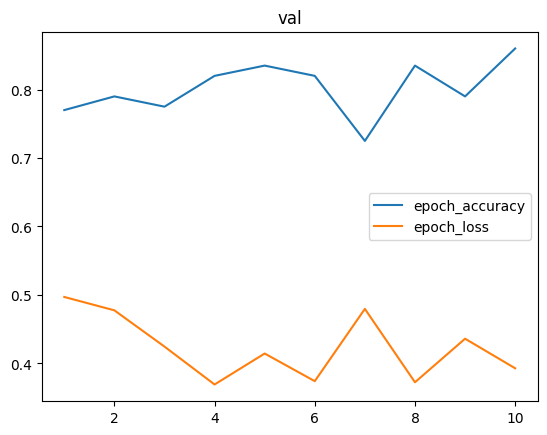

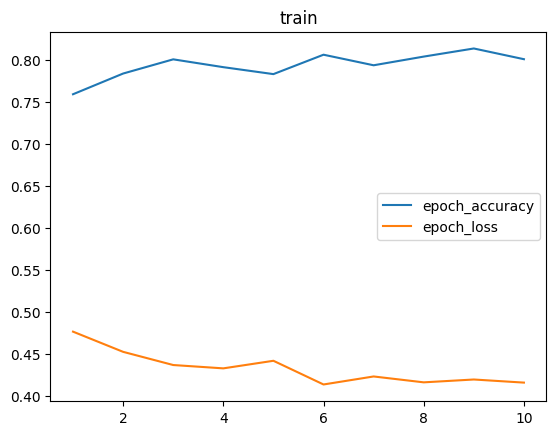

In [17]:
lr = 0.001 # learning_rate
batch_size = 50 # we will use mini-batch method

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(params = model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot(epoch_val_accuracy_list, epoch_val_loss_list, "val")
show_plot(epoch_accuracy_list, [i.data for i in epoch_loss_list], "train")

Epoch : 1, train accuracy : 0.8187500238418579, train loss : 0.39296334981918335
Epoch : 1, val_accuracy : 0.8125, val_loss : 0.3872631788253784
Epoch : 2, train accuracy : 0.8174999952316284, train loss : 0.41168466210365295
Epoch : 2, val_accuracy : 0.7875000238418579, val_loss : 0.4387734830379486
Epoch : 3, train accuracy : 0.8262499570846558, train loss : 0.394332617521286
Epoch : 3, val_accuracy : 0.7875000238418579, val_loss : 0.4417746067047119
Epoch : 4, train accuracy : 0.8125, train loss : 0.3936968743801117
Epoch : 4, val_accuracy : 0.824999988079071, val_loss : 0.377699077129364
Epoch : 5, train accuracy : 0.8199999928474426, train loss : 0.371071457862854
Epoch : 5, val_accuracy : 0.824999988079071, val_loss : 0.37132182717323303
Epoch : 6, train accuracy : 0.824999988079071, train loss : 0.37043535709381104
Epoch : 6, val_accuracy : 0.831250011920929, val_loss : 0.3440091907978058
Epoch : 7, train accuracy : 0.8206250071525574, train loss : 0.4055631458759308
Epoch : 7, 

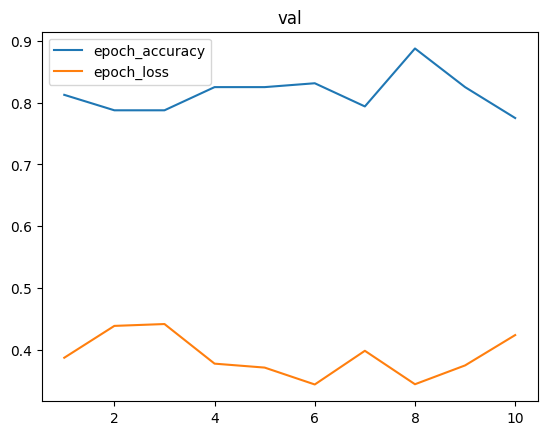

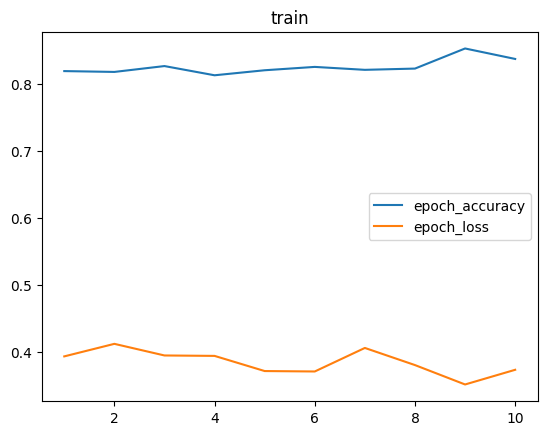

In [18]:
lr = 0.001 # learning_rate
batch_size = 200 # we will use mini-batch method

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(params = model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot(epoch_val_accuracy_list, epoch_val_loss_list, "val")
show_plot(epoch_accuracy_list, [i.data for i in epoch_loss_list], "train")

Epoch : 1, train accuracy : 0.8236207365989685, train loss : 0.37645402550697327
Epoch : 1, val_accuracy : 0.800000011920929, val_loss : 0.4358934164047241
Epoch : 2, train accuracy : 0.8467241525650024, train loss : 0.3588372468948364
Epoch : 2, val_accuracy : 0.800000011920929, val_loss : 0.37705761194229126
Epoch : 3, train accuracy : 0.8248275518417358, train loss : 0.36598503589630127
Epoch : 3, val_accuracy : 0.7949999570846558, val_loss : 0.442160964012146
Epoch : 4, train accuracy : 0.8308619856834412, train loss : 0.3632150888442993
Epoch : 4, val_accuracy : 0.800000011920929, val_loss : 0.4090096652507782
Epoch : 5, train accuracy : 0.8299999833106995, train loss : 0.3635236918926239
Epoch : 5, val_accuracy : 0.809999942779541, val_loss : 0.40599381923675537
Epoch : 6, train accuracy : 0.8418965339660645, train loss : 0.35440218448638916
Epoch : 6, val_accuracy : 0.8500000238418579, val_loss : 0.36499667167663574
Epoch : 7, train accuracy : 0.8362069129943848, train loss : 0.

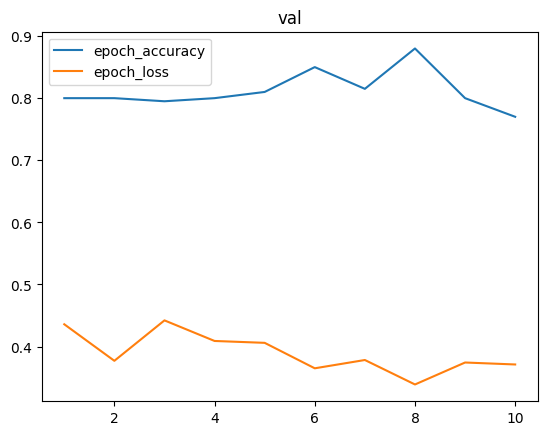

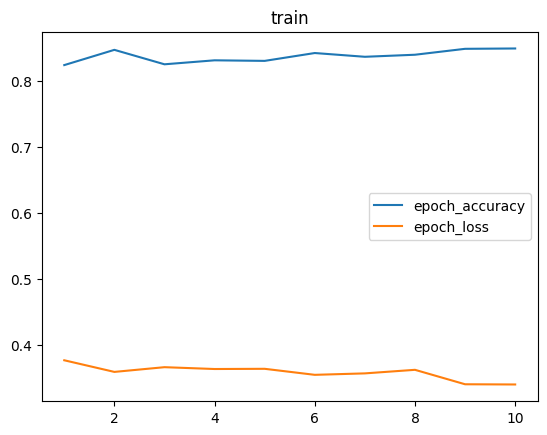

In [19]:
lr = 0.0005 # learning_rate
batch_size = 50 # we will use mini-batch method

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(params = model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot(epoch_val_accuracy_list, epoch_val_loss_list, "val")
show_plot(epoch_accuracy_list, [i.data for i in epoch_loss_list], "train")

Epoch : 1, train accuracy : 0.8503332734107971, train loss : 0.3303964138031006
Epoch : 1, val_accuracy : 0.8533333539962769, val_loss : 0.3988979458808899
Epoch : 2, train accuracy : 0.8616666793823242, train loss : 0.3344993591308594
Epoch : 2, val_accuracy : 0.8183333277702332, val_loss : 0.34810003638267517
Epoch : 3, train accuracy : 0.8603333234786987, train loss : 0.3331384062767029
Epoch : 3, val_accuracy : 0.8133333325386047, val_loss : 0.3345140218734741
Epoch : 4, train accuracy : 0.8529999852180481, train loss : 0.33187803626060486
Epoch : 4, val_accuracy : 0.8116666674613953, val_loss : 0.3835115432739258
Epoch : 5, train accuracy : 0.862666666507721, train loss : 0.32347381114959717
Epoch : 5, val_accuracy : 0.846666693687439, val_loss : 0.36901482939720154
Epoch : 6, train accuracy : 0.8529999852180481, train loss : 0.3254619538784027
Epoch : 6, val_accuracy : 0.8250000476837158, val_loss : 0.35772716999053955
Epoch : 7, train accuracy : 0.8400000333786011, train loss : 

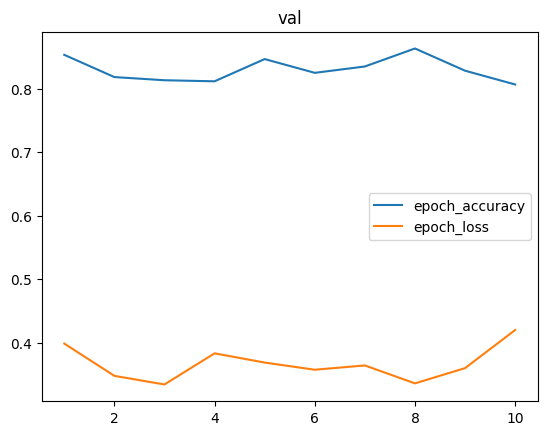

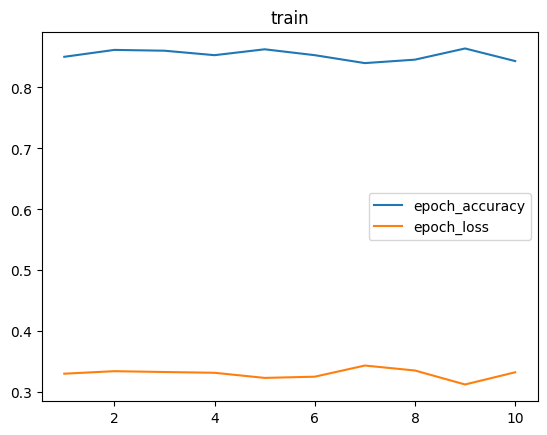

In [20]:
lr = 0.0005 # learning_rate
batch_size = 100 # we will use mini-batch method

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(params = model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot(epoch_val_accuracy_list, epoch_val_loss_list, "val")
show_plot(epoch_accuracy_list, [i.data for i in epoch_loss_list], "train")

Epoch : 1, train accuracy : 0.8550000190734863, train loss : 0.33152875304222107
Epoch : 1, val_accuracy : 0.84375, val_loss : 0.36894071102142334
Epoch : 2, train accuracy : 0.8587499856948853, train loss : 0.3327862024307251
Epoch : 2, val_accuracy : 0.893750011920929, val_loss : 0.3422507643699646
Epoch : 3, train accuracy : 0.8706250190734863, train loss : 0.29971396923065186
Epoch : 3, val_accuracy : 0.8374999761581421, val_loss : 0.3707180321216583
Epoch : 4, train accuracy : 0.8662499785423279, train loss : 0.30666548013687134
Epoch : 4, val_accuracy : 0.8125, val_loss : 0.38635873794555664
Epoch : 5, train accuracy : 0.8712499737739563, train loss : 0.3090708255767822
Epoch : 5, val_accuracy : 0.8374999761581421, val_loss : 0.3866153359413147
Epoch : 6, train accuracy : 0.8518750667572021, train loss : 0.3340354859828949
Epoch : 6, val_accuracy : 0.824999988079071, val_loss : 0.3508526682853699
Epoch : 7, train accuracy : 0.8618749976158142, train loss : 0.3211008310317993
Epoc

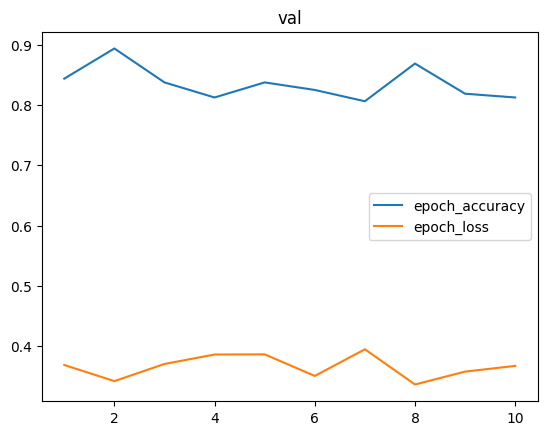

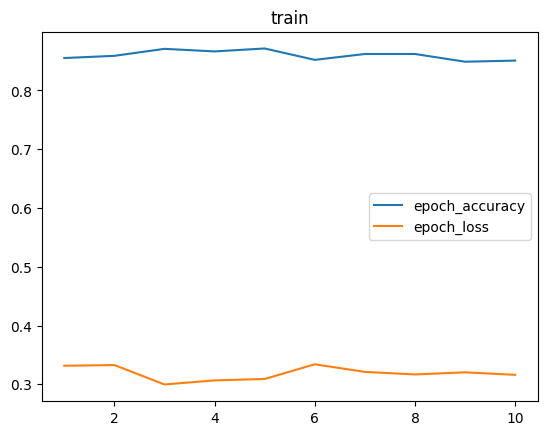

In [21]:
lr = 0.0005 # learning_rate
batch_size = 200 # we will use mini-batch method

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(params = model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot(epoch_val_accuracy_list, epoch_val_loss_list, "val")
show_plot(epoch_accuracy_list, [i.data for i in epoch_loss_list], "train")

Epoch : 1, train accuracy : 0.7577586770057678, train loss : 0.5187745690345764
Epoch : 1, val_accuracy : 0.7300000190734863, val_loss : 0.5986436605453491
Epoch : 2, train accuracy : 0.7717241644859314, train loss : 0.45403462648391724
Epoch : 2, val_accuracy : 0.8500000238418579, val_loss : 0.3760344088077545
Epoch : 3, train accuracy : 0.7774137258529663, train loss : 0.4640773832798004
Epoch : 3, val_accuracy : 0.7749999761581421, val_loss : 0.504422664642334
Epoch : 4, train accuracy : 0.7851724028587341, train loss : 0.4512585997581482
Epoch : 4, val_accuracy : 0.75, val_loss : 0.4970914125442505
Epoch : 5, train accuracy : 0.7920690178871155, train loss : 0.43488654494285583
Epoch : 5, val_accuracy : 0.800000011920929, val_loss : 0.43113085627555847
Epoch : 6, train accuracy : 0.7944827079772949, train loss : 0.43805602192878723
Epoch : 6, val_accuracy : 0.7699999809265137, val_loss : 0.47613418102264404
Epoch : 7, train accuracy : 0.8151723742485046, train loss : 0.405845671892

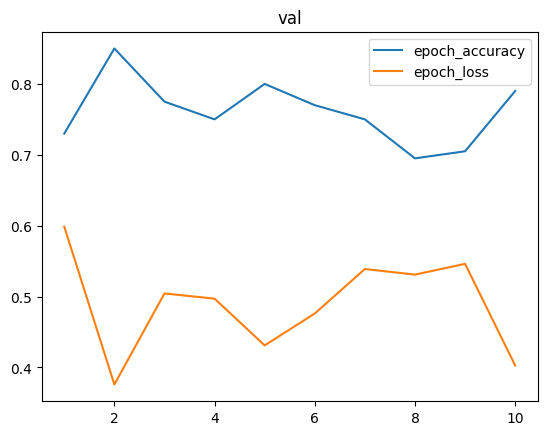

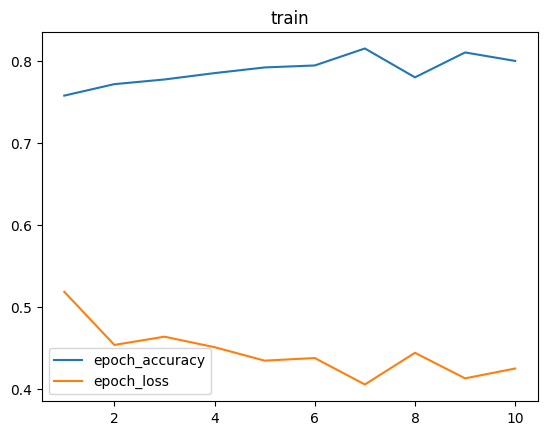

In [22]:
lr = 0.005 # learning_rate
batch_size = 50 # we will use mini-batch method

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(params = model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot(epoch_val_accuracy_list, epoch_val_loss_list, "val")
show_plot(epoch_accuracy_list, [i.data for i in epoch_loss_list], "train")

Epoch : 1, train accuracy : 0.7916666865348816, train loss : 0.43549874424934387
Epoch : 1, val_accuracy : 0.8250000476837158, val_loss : 0.41952818632125854
Epoch : 2, train accuracy : 0.8036667108535767, train loss : 0.42452526092529297
Epoch : 2, val_accuracy : 0.84333336353302, val_loss : 0.3749305009841919
Epoch : 3, train accuracy : 0.815333366394043, train loss : 0.40594756603240967
Epoch : 3, val_accuracy : 0.8383333683013916, val_loss : 0.38302749395370483
Epoch : 4, train accuracy : 0.7926665544509888, train loss : 0.42890632152557373
Epoch : 4, val_accuracy : 0.8700000047683716, val_loss : 0.3219318389892578
Epoch : 5, train accuracy : 0.8223333954811096, train loss : 0.3737112283706665
Epoch : 5, val_accuracy : 0.8483333587646484, val_loss : 0.4032320976257324
Epoch : 6, train accuracy : 0.81166672706604, train loss : 0.39426225423812866
Epoch : 6, val_accuracy : 0.8316666483879089, val_loss : 0.4038928747177124
Epoch : 7, train accuracy : 0.8143333196640015, train loss : 0

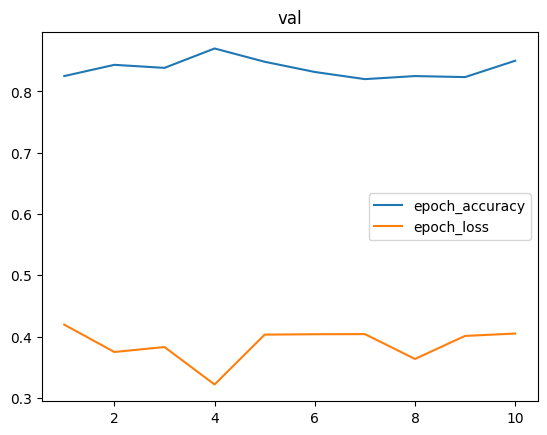

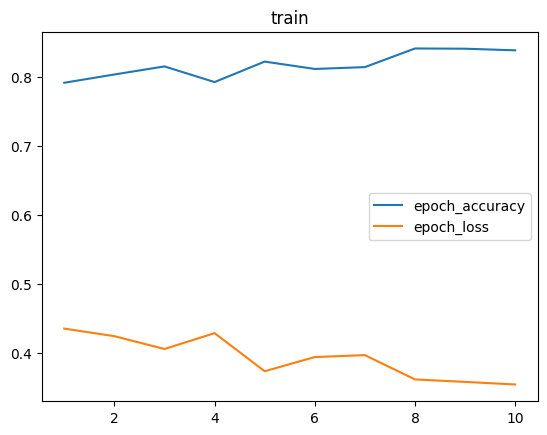

In [23]:
lr = 0.005 # learning_rate
batch_size = 100 # we will use mini-batch method

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(params = model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot(epoch_val_accuracy_list, epoch_val_loss_list, "val")
show_plot(epoch_accuracy_list, [i.data for i in epoch_loss_list], "train")

Epoch : 1, train accuracy : 0.8356249928474426, train loss : 0.3534931242465973
Epoch : 1, val_accuracy : 0.8812500238418579, val_loss : 0.3320534825325012
Epoch : 2, train accuracy : 0.8368749618530273, train loss : 0.3585537374019623
Epoch : 2, val_accuracy : 0.856249988079071, val_loss : 0.34375450015068054
Epoch : 3, train accuracy : 0.8618749976158142, train loss : 0.31677964329719543
Epoch : 3, val_accuracy : 0.8500000238418579, val_loss : 0.340129554271698
Epoch : 4, train accuracy : 0.8512500524520874, train loss : 0.32387644052505493
Epoch : 4, val_accuracy : 0.862500011920929, val_loss : 0.3170284926891327
Epoch : 5, train accuracy : 0.8568750023841858, train loss : 0.31843137741088867
Epoch : 5, val_accuracy : 0.8500000238418579, val_loss : 0.3610392212867737
Epoch : 6, train accuracy : 0.8681250810623169, train loss : 0.29457879066467285
Epoch : 6, val_accuracy : 0.862500011920929, val_loss : 0.34608280658721924
Epoch : 7, train accuracy : 0.8456249833106995, train loss : 0

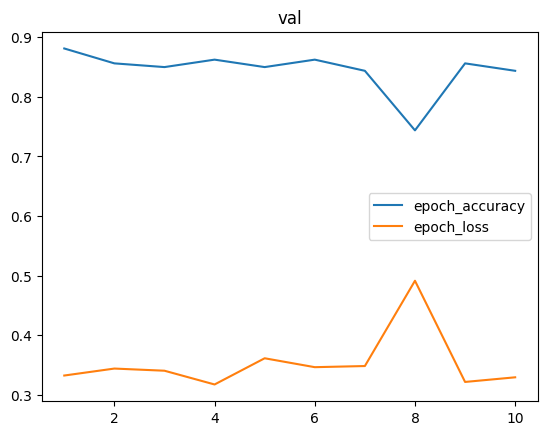

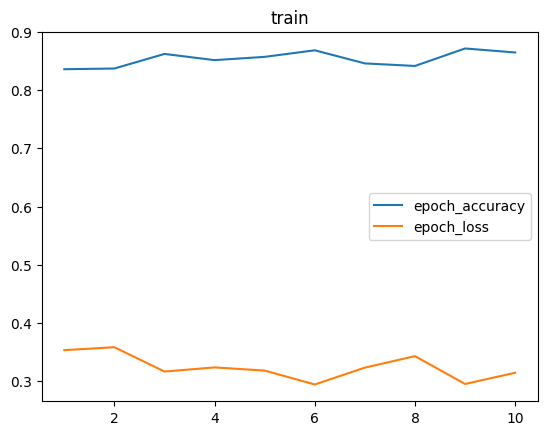

In [24]:
lr = 0.005 # learning_rate
batch_size = 200 # we will use mini-batch method

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(params = model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot(epoch_val_accuracy_list, epoch_val_loss_list, "val")
show_plot(epoch_accuracy_list, [i.data for i in epoch_loss_list], "train")

In [51]:
dog_probs = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        preds = model(images)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip(labels, preds_list))

dog_probs.sort(key = lambda x : int(x[0]))     
idx = list(map(lambda x: x[0],dog_probs))
prob = list(map(lambda x: x[1],dog_probs))

submission = pd.DataFrame({'id':idx,'label':prob})

submission

,id,label
0,800,0.063607
1,801,0.226991
2,802,0.006177
3,803,0.255018
4,804,0.057091
...,...,...
195,1895,0.798897
196,1896,0.188741
197,1897,0.976088
198,1898,0.995582


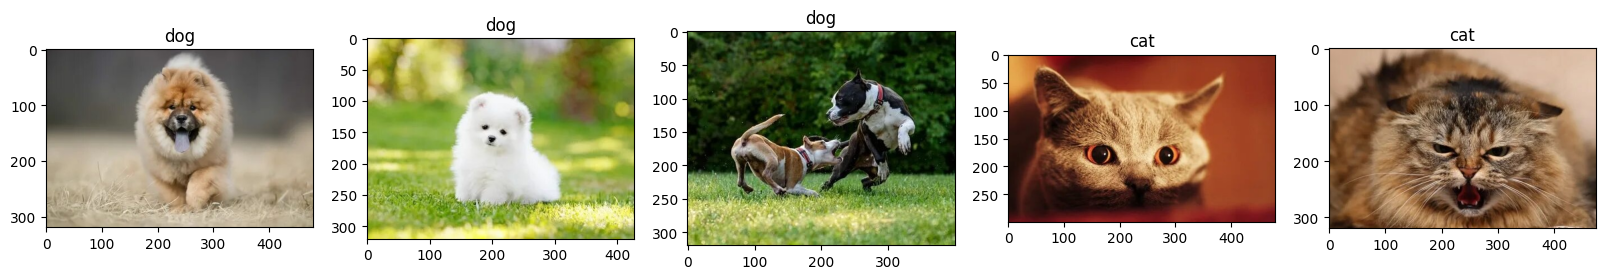

In [52]:
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(1, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_path, f'{i}.jpg')
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)

In [54]:
torch.save(model.state_dict(), os.path.join("C:/Users/Professional/Desktop/labpython", "weight.pt"))

In [55]:
mymodel = Cnn()
mymodel.load_state_dict(torch.load(os.path.join("C:/Users/Professional/Desktop/labpython", "weight.pt")))

<All keys matched successfully>

In [59]:
import random
from PIL import Image


img_path = os.path.join(test_path, f'{i}.jpg')

img = Image.open(img_path)
img_transformed = test_transforms(img).unsqueeze(dim=0)

output = mymodel(img_transformed)

output

tensor([[-0.5744, -2.0277]], grad_fn=<AddmmBackward0>)